In [100]:
from __future__ import print_function
import os, sys
sys.path.insert(0, os.environ['PROJECT_PATH'])

In [101]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

sns.set()
%matplotlib inline

In [102]:
path_to_locs = os.path.join(os.environ['DATA_PATH'], 'interim', 'augmented_meetup_locations.csv')
loc_df = pd.read_csv(path_to_locs, encoding='latin1')

In [103]:
sample_cities = [ 'Charlottesville', 'Trenton', 'Boulder' ]
sample_loc_df = loc_df[ loc_df['City'].isin(sample_cities) ]

In [104]:
path_to_sample_events = os.path.join(os.environ['DATA_PATH'], 'raw', 'topics', 'sample_events.csv')

In [105]:
sample_events_df = pd.read_csv(path_to_sample_events, encoding='latin1')

In [106]:
master_df = pd.merge(sample_events_df, sample_loc_df[ ['City','MSA_NAME', 'Latitude', 'Longitude'] ], 
                                      left_on=['latitude', 'longitude'], right_on=['Latitude', 'Longitude'], 
                                      how='inner').drop(['Latitude', 'Longitude'], axis=1)
# print(sample_events_df.shape, master_df.shape)
master_df.head()

,id,time,group.category.id,yes_rsvp_count,latitude,longitude,City,MSA_NAME
0,rrtlvlywqbvb,1513470600000,34.0,4,46.2,-112.08,Boulder,"Helena, MT Micro Area"
1,pblrxlywqbbc,1513821600000,22.0,3,46.2,-112.08,Boulder,"Helena, MT Micro Area"
2,xscxtlywqbcc,1513908000000,34.0,4,46.2,-112.08,Boulder,"Helena, MT Micro Area"
3,244413343,1514649600000,23.0,9,46.2,-112.08,Boulder,"Helena, MT Micro Area"
4,245727930,1516239000000,18.0,7,46.2,-112.08,Boulder,"Helena, MT Micro Area"


## Exploring the time events took place

In [107]:
master_df['formatted_time'] = pd.to_datetime(master_df['time'], unit='ms')
master_df.head()

,id,time,group.category.id,yes_rsvp_count,latitude,longitude,City,MSA_NAME,formatted_time
0,rrtlvlywqbvb,1513470600000,34.0,4,46.2,-112.08,Boulder,"Helena, MT Micro Area",2017-12-17 00:30:00
1,pblrxlywqbbc,1513821600000,22.0,3,46.2,-112.08,Boulder,"Helena, MT Micro Area",2017-12-21 02:00:00
2,xscxtlywqbcc,1513908000000,34.0,4,46.2,-112.08,Boulder,"Helena, MT Micro Area",2017-12-22 02:00:00
3,244413343,1514649600000,23.0,9,46.2,-112.08,Boulder,"Helena, MT Micro Area",2017-12-30 16:00:00
4,245727930,1516239000000,18.0,7,46.2,-112.08,Boulder,"Helena, MT Micro Area",2018-01-18 01:30:00


In [108]:
from datetime import datetime
from datetime import timedelta

curr_date = datetime.now().date()

start_of_curr_month = curr_date.replace(day=1)
three_months_from_now = start_of_curr_month + timedelta(days=3*32)
three_months_from_now = three_months_from_now.replace(day=curr_date.day)

# restricting to events taking place three months from now
master_df = master_df[ master_df['formatted_time'] <= three_months_from_now]

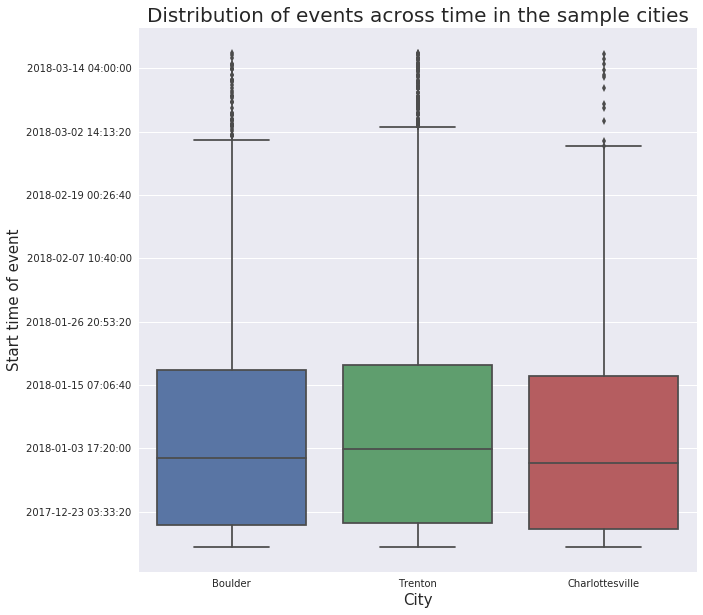

In [109]:
plt.subplots(figsize=(10, 10))
ax = sns.boxplot(x='City', y='time', data=master_df)

yticks = ax.get_yticks()
ax.set_yticklabels([pd.to_datetime(tm, unit='ms') for tm in yticks])
ax.axes.set_title("Distribution of events across time in the sample cities",fontsize=20)
ax.set_xlabel("City",fontsize=15)
ax.set_ylabel("Start time of event",fontsize=15)

print()

## Exploring the number of events across the sample cities

In [110]:
master_df.groupby('City').count()

,id,time,group.category.id,yes_rsvp_count,latitude,longitude,MSA_NAME,formatted_time
City,,,,,,,,
Boulder,2465,2465,2465,2465,2465,2465,2465,2465
Charlottesville,414,414,414,414,414,414,414,414
Trenton,6395,6395,6394,6395,6395,6395,5110,6395


## Exploring the popularity of events in each category across the sample cities

### By raw event count 

In [111]:
import requests

url_template = "https://api.meetup.com/2/categories?&sign=true&photo-host=public&page=40&key={api_key}"

res = requests.get(url_template.format(api_key=os.environ['API_KEY']))

payload = res.json()

category_ids = { item['id']: item['name'] for item in payload['results'] }

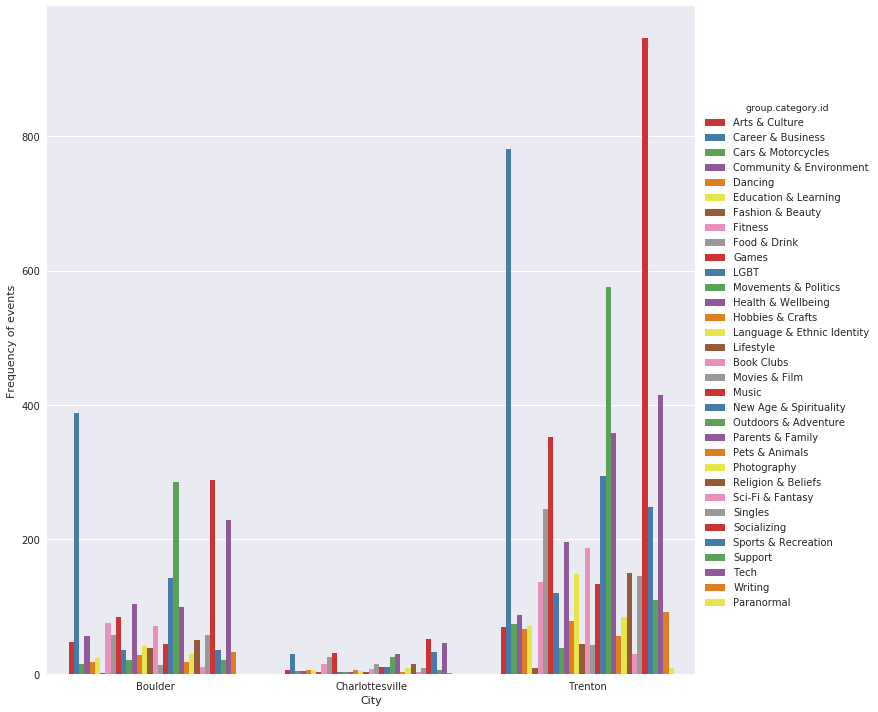

In [115]:
events_count = master_df.groupby(['City', 'group.category.id']).count().reset_index()

events_count['group.category.id'] = events_count['group.category.id'].apply(lambda x: category_ids[x])

g = sns.factorplot(x='City', y='id', hue='group.category.id', palette=sns.color_palette('Set1', 100), 
                   size=10, kind='bar', data=events_count)
g.set_ylabels('Frequency of events')
print()

### Top 5 Categories

In [117]:
trenton_top5 = events_count[ events_count['City'] == 'Trenton'].sort_values('id', ascending=False).head()
cville_top5 = events_count[ events_count['City'] == 'Charlottesville'].sort_values('id', ascending=False).head()
boulder_top5 = events_count[ events_count['City'] == 'Boulder'].sort_values('id', ascending=False).head()

print('\nTrenton Top 5:\n', trenton_top5[ ['group.category.id', 'yes_rsvp_count'] ]) 
print('\nCville Top 5:\n', cville_top5[ ['group.category.id', 'yes_rsvp_count'] ])
print('\nBoulder Top 5:\n', boulder_top5[ ['group.category.id', 'yes_rsvp_count'] ])


Trenton Top 5:
        group.category.id  yes_rsvp_count
92           Socializing             946
65     Career & Business             781
84  Outdoors & Adventure             575
95                  Tech             415
86      Parents & Family             358

Cville Top 5:
       group.category.id  yes_rsvp_count
59          Socializing              52
62                 Tech              46
60  Sports & Recreation              33
41                Games              31
53     Parents & Family              30

Boulder Top 5:
          group.category.id  yes_rsvp_count
1        Career & Business             388
27             Socializing             289
20    Outdoors & Adventure             286
30                    Tech             229
19  New Age & Spirituality             142


### By attendance per million people in each city 

In [126]:
path_to_msa_populations = os.path.join(os.environ['DATA_PATH'], 'external', 'msa_population.xlsx')
msa_pop_df = pd.read_excel(path_to_msa_populations)

augmented_df = pd.merge(master_df, msa_pop_df[ ['cbsaname15', 'pop_acs16'] ], how='inner', 
                        left_on='MSA_NAME', right_on='cbsaname15').drop('cbsaname15', axis=1)

# add up the populations of msa in each city to serve as the city's population
pop_by_city = augmented_df.groupby('City').sum().reset_index()

augmented_df.drop('pop_acs16', axis=1, inplace=True)
augmented_df = pd.merge(augmented_df, pop_by_city[ ['City', 'pop_acs16'] ], how='inner', on='City')

# normalize the event attendance by the city's population
augmented_df['attendance_norm'] = ( augmented_df['yes_rsvp_count'] / augmented_df['pop_acs16'] )

events_attendance = augmented_df.groupby( ['City', 'group.category.id' ] ).sum().reset_index()

events_attendance['group.category.id'] = events_attendance['group.category.id'].apply(lambda x: category_ids[x])

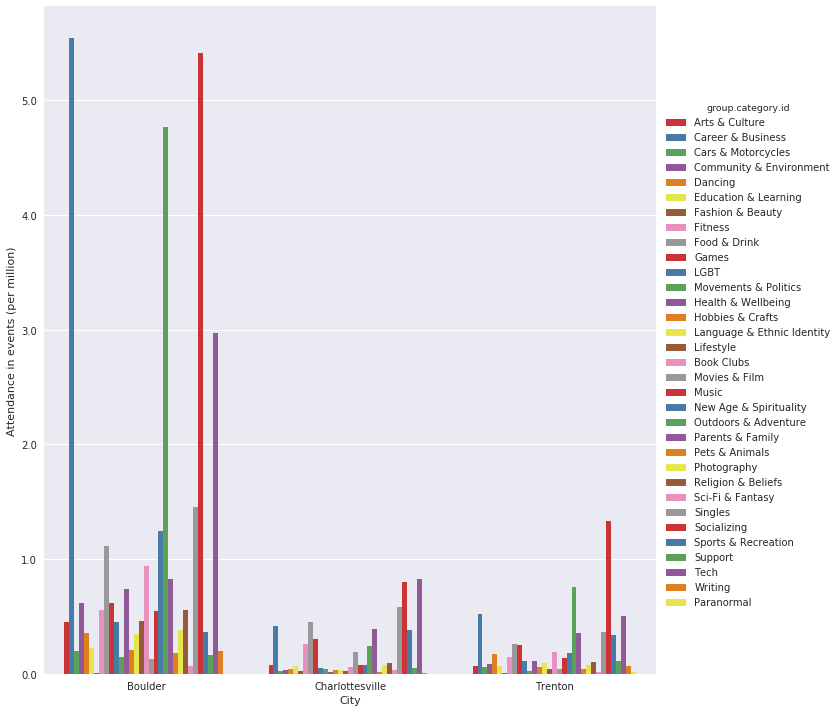

In [127]:
g = sns.factorplot(x='City', y='attendance_norm', hue='group.category.id', palette=sns.color_palette('Set1', 100), 
                   size=10, kind='bar', data=events_attendance)
g.set_ylabels('Attendance in events (per million)')
ax = g.axes.flatten()[0]
ax.set_yticklabels([ tick * 1000000 for tick in ax.get_yticks()])
print() 

In [128]:
trenton_top5 = events_attendance[ events_attendance['City'] == 'Trenton'].sort_values('attendance_norm', ascending=False).head()
cville_top5 = events_attendance[ events_attendance['City'] == 'Charlottesville'].sort_values('attendance_norm', ascending=False).head()
boulder_top5 = events_attendance[ events_attendance['City'] == 'Boulder'].sort_values('attendance_norm', ascending=False).head()

print('\nTrenton Top 5:\n', trenton_top5[ ['group.category.id', 'yes_rsvp_count'] ]) 
print('\nCville Top 5:\n', cville_top5[ ['group.category.id', 'yes_rsvp_count'] ])
print('\nBoulder Top 5:\n', boulder_top5[ ['group.category.id', 'yes_rsvp_count'] ])


Trenton Top 5:
        group.category.id  yes_rsvp_count
92           Socializing            9965
84  Outdoors & Adventure            5643
65     Career & Business            3891
95                  Tech            3786
91               Singles            2738

Cville Top 5:
     group.category.id  yes_rsvp_count
62               Tech             547
59        Socializing             529
58            Singles             383
40       Food & Drink             297
33  Career & Business             276

Boulder Top 5:
        group.category.id  yes_rsvp_count
1      Career & Business            4391
27           Socializing            4288
20  Outdoors & Adventure            3775
30                  Tech            2351
26               Singles            1154


### By attendance per million people and per event in each city

In [129]:
# redo the events count due to some invalid rows being dropped (some MSAs did not have a pop. count)
events_count = augmented_df.groupby( ['City', 'group.category.id'] ).count().reset_index()

# normalize the attendance further by the number of events in each city and each category
events_attendance['attendance_norm'] = events_attendance['attendance_norm'] / events_count['id']

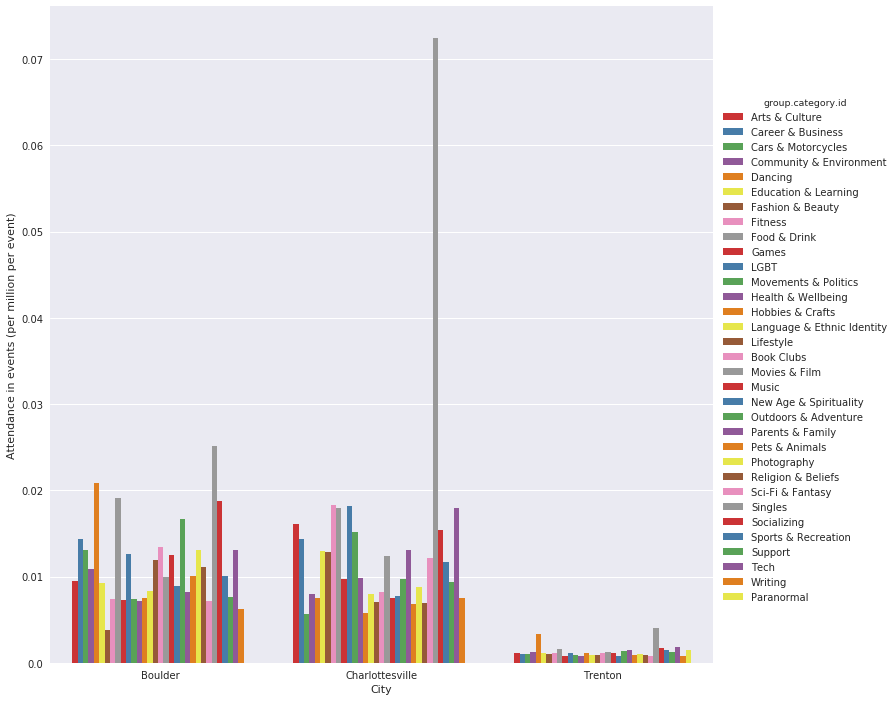

In [130]:
g = sns.factorplot(x='City', y='attendance_norm', hue='group.category.id', palette=sns.color_palette('Set1', 100), 
                   size=10, kind='bar', data=events_attendance)
g.set_ylabels('Attendance in events (per million per event)')
ax = g.axes.flatten()[0]
ax.set_yticklabels( [ tick * 1000000 for tick in ax.get_yticks()] )
print()

In [131]:
trenton_top5 = events_attendance[ events_attendance['City'] == 'Trenton'].sort_values('attendance_norm', ascending=False).head()
cville_top5 = events_attendance[ events_attendance['City'] == 'Charlottesville'].sort_values('attendance_norm', ascending=False).head()
boulder_top5 = events_attendance[ events_attendance['City'] == 'Boulder'].sort_values('attendance_norm', ascending=False).head()

print('\nTrenton Top 5:\n', trenton_top5[ ['group.category.id', 'yes_rsvp_count'] ]) 
print('\nCville Top 5:\n', cville_top5[ ['group.category.id', 'yes_rsvp_count'] ])
print('\nBoulder Top 5:\n', boulder_top5[ ['group.category.id', 'yes_rsvp_count'] ])


Trenton Top 5:
    group.category.id  yes_rsvp_count
91           Singles            2738
68           Dancing            1317
95              Tech            3786
92       Socializing            9965
72      Food & Drink            1974

Cville Top 5:
    group.category.id  yes_rsvp_count
58           Singles             383
39           Fitness             169
42              LGBT              36
62              Tech             547
40      Food & Drink             297

Boulder Top 5:
        group.category.id  yes_rsvp_count
26               Singles            1154
4                Dancing             281
8           Food & Drink             880
27           Socializing            4288
20  Outdoors & Adventure            3775
